#Welcome to the object detection with YOLO workshop!

In this notebook, you will not only learn about object detection but also have the chance to try it out yourself. The content has the following structure:

*   Theoretical Section about object detection and the YOLO model
*   Code it yourself
*   Fine-tuning YOLOv5



# Theoretical section about object detection and the YOLO model

In this first section you will get a theoretical overview of the topic. This includes:


1.   What are localization and detection?
2.   The main idea of YOLO
3.   How does the YOLO model detect objects?
4.   Intersection over Union
5.   Non-Max Suppression
6.   The full YOLO architecture
7.   References





### 1. What are localization and detection? 

**Object localization** means putting a bounding box around the position of an object in an image.

The goal of **object detection** is to have both, a classification and a localization of the object (as seen below). 








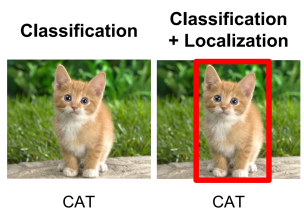


There are **single object localization** tasks with only one object in the image or general **object detection** tasks with possibly multiple objects in the image at once (as shown below).

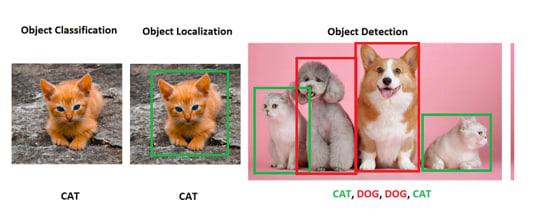

**How does classification with localization work?** 

For classification with localization, more outputs are added to the output of the classifier model. These new values define a bounding box on the object.

For example, a cat/dog classifier normally outputs a single class label. The network should be modified to output the class label and four points that specify the red box shown below. Models can also include another output value that measures the confidence of the detection.

There are multiple ways to specify a bounding box with 4 points. One option is:  
* mid-point (bx, by)
* height (bh)
* width (bw)

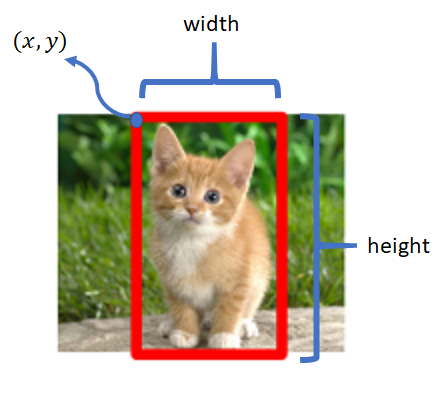

The output Y would then be the following vector: 

$Y =
 \begin{pmatrix}
  y_{1} :pc \\
  y_{2}: bx  \\
  y_{3}: by  \\
  y_{4}: bh  \\
  y_{5}: bw  \\
  y_{6}: c1 (ClassLabel)  \\
  y_{7}: c2 (ClassLabel)
 \end{pmatrix}$





- pc is the probability of an object being present in the grid (confidence of the detection)
- bx, by, bh, bw specify the bounding box if there is an object
- c1, c2 (and possibly more) represent the classes.

### 2. The main idea of YOLO


There are two main ways to approach the goal of object detection:  


*   **Two-Stage Algorithms**:  
First, detect possible object regions. For each proposed region, classify this region.  
Popular two-step algorithms like Fast-RCNN and Faster-RCNN typically use a Region Proposal Network that proposes regions of interest that might contain objects.  
*   **One-Stage Algorithms**:  
One model makes predictions of bounding boxes and class probabilities all at once.

The model we will focus on today is called **YOLO** ("you only look once"). It is an end-to-end neural network performing one-stage object detection.  
The model developed in 2015 was an improvement over previous architectures in multiple ways.  
In addition to increased accuracy in predictions, YOLO has the inherent advantage of speed.  
A single convolutional network simultaneously predicts multiple bounding boxes and class probabilities for those boxes. Methods that use Region Proposal Networks thus end up performing multiple iterations for the same image, while YOLO gets away with a single iteration.  
YOLO also implements two post-processing steps that will be explained later: IoU (Intersect over Union) and NMS (Non-maximum suppression).

* The system divides the input image into a grid. If the center of an object falls into a grid cell, that grid cell is responsible for detecting that object.

* Each grid cell predicts multiple bounding boxes of different shapes and sizes and confidence scores for those boxes. These confidence scores reflect how confident the model is that the box contains an object and also how accurate it thinks the box is that it predicts.

* Each bounding box consists of 5 predictions: x, y, w, h, and confidence. The (x, y) coordinates represent the center of the box relative to the bounds of the grid cell. The width and height are predicted relative to the whole image. Finally, the confidence prediction represents the IOU between the predicted box and any ground truth box. Each grid cell also predicts C conditional class probabilities, Pr(Classi |Object).

### 3. How does the YOLO model detect objects?



YOLO takes an input image and divides it using a *SxS* size grid.  
Each grid cell predicts *B* bounding boxes of different shapes and sizes and confidence scores for those boxes. Each cell is responsible for all objects whose **center is within this box**. These confidence scores reflect how confident the model is that the box contains an object and also how accurate it thinks the box is that it predicts.
For illustration, we use a 3*3 grid as seen below:  

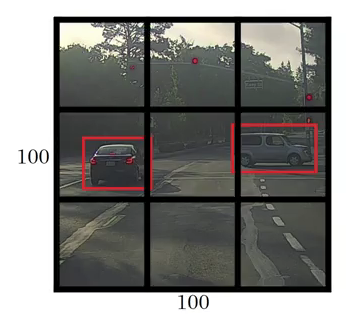

For each of the B bounding boxes in a cell, YOLO outputs a vector:

  $Y =
 \begin{pmatrix}
 pc \\
 bx  \\
 by  \\
 bh  \\
 bw
 \end{pmatrix}$


As described before, the value pc is used to output whether YOLO detected an object or not, meaning the confidence of the detection.  

The model also needs to output C conditional class probabilities, Pr(Classi |Object). These probabilities are conditioned on the grid cell containing an object.  

For the classes there are two ways to implement the output:
*   Predict the classes for each bounding box. Each cell has the output shape B*(5+C) for C available classes.
*   Predict the classes only for the whole cell, meaning no separate values for each bounding box. Each cell has the output shape B*5+C for C available classes.

The original YOLO architecture uses the second option and there is only one set of class probabilities per grid cell, regardless of the number of boxes B.

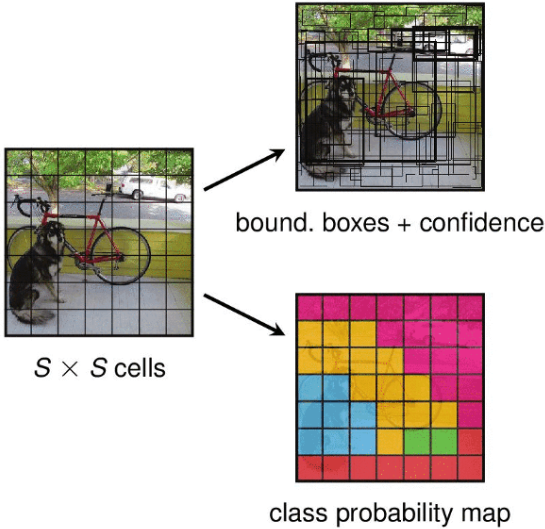

**Two examples for cells:**

The first grid from the above example does not contain an object.


  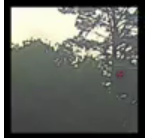

The PC value should therefore be 0. The output of the other values does not matter since the class probabilities are only conditional on an object being detected and the shape of the bounding box also does not matter if no object is present in the cell.

All B bounding boxes for the cell should be

  $Y =
 \begin{pmatrix}
 0 \\
 ?  \\
 ?  \\
 ?  \\
 ? 
 \end{pmatrix}$

Here, ‘?’ means that it doesn’t matter what bx, by, bh, and bw contain as there is no object in the grid.

In another grid cell, a car is present.


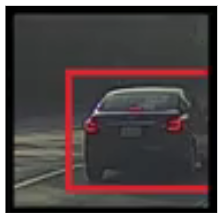



- Before we write the y label for this grid, it’s important to first understand how YOLO decides whether there actually is an object in the grid. In the original image, there are two objects (two cars), so YOLO will take the mid-point of these two objects and these objects will be assigned to the grid which contains the mid-point of these objects. The y label for the center left grid with the car (above image) will be:
$Y =
 \begin{pmatrix}
  1 \\
  bx  \\
  by \\
  bh  \\
  bw
 \end{pmatrix}$

    - bx, by, bh, bw will be calculated relative to the particular grid cell we are dealing with.
- We could now compare the target vector of the image with the predictions.
- Even if an object spans out to more than one grid, it will only be assigned to a single grid in which its mid-point is located. We can reduce the chances of multiple objects having their center in the same grid cell by increasing the number of grids (19 X 19, for example).




How to encode the bounding boxes? 
- As I mentioned earlier, bx, by, bh, and bw are calculated relative to the grid cell we are dealing with. Consider the center-right grid which contains a car:

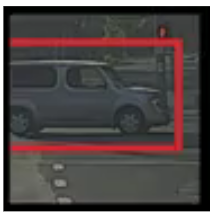





*   So, bx, by, bh, and bw will be calculated relative to this grid only. 


### 4. Intersection over Union 


**How can we decide whether the predicted bounding box matches the data or is a wrong prediction?**



**Intersection over Union** is a popular metric to measure localization accuracy and calculate localization errors in object detection models. It determines how the projected bounding box and the actual bounding box intersect compared to the size of their union.  
We will showcase IoU with the image below: 


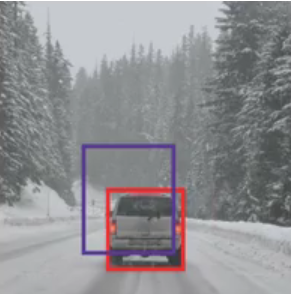

Here, the red box is the ground truth bounding box and the blue box is the predicted one.

To calculate the IoU with the prediction and the ground truth, we first take the *intersecting area* between the bounding boxes. Following this, we calculate the total area covered by the two bounding boxes, also known as the *union*.

The intersection divided by the union provides a good estimate of how close the bounding box is to the original prediction.

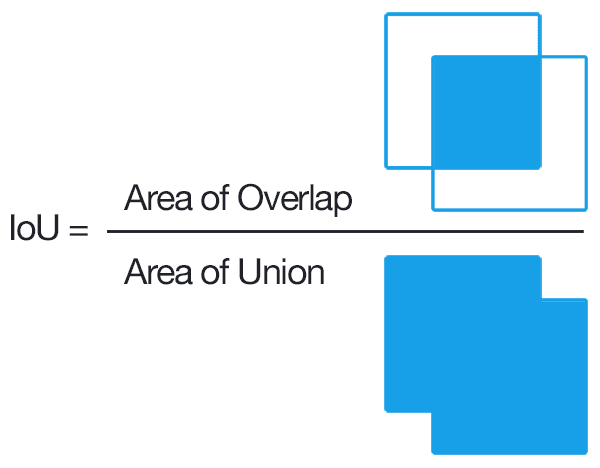

To measure how many objects were detected correctly, a threshold for the minimum IoU of detection and ground truth is needed. Using a threshold of 0.5 means that the prediction is accurate if the IoU is higher than 0.5.

### 5. Non-Max Suppresion 

The object detections contain a lot of duplicate predictions due to multiple cells predicting the same object with different bounding box predictions.

YOLO makes use of Non Maximal Suppression to deal with this issue.

Consider the image below:

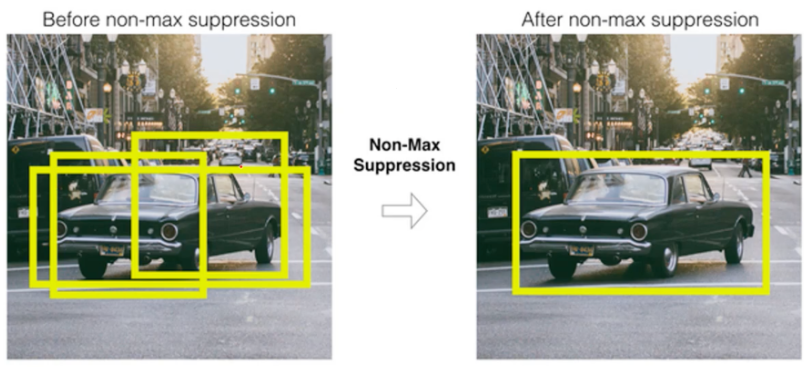



Since we're running image classfication and localization algorithm on every grid cell, it is possible that many of them contain the same object. Thus, we end up with multiple detections of each object.


Non-Max Suppression cleans up these detections to end up with just one detection per object by following these three steps: 
1. Discard all boxes with pc <= 0.6 (here 0.6 is a convention).
2. Pick the box with the largest value of pc (highest confidence).
3. Discard all remaining boxes with IoU >= 0.5 (likely a detection of the same object).

### 6. The full YOLO architecture









Combining all mentioned steps (including non-max suppression) leads to the full YOLO architecture:

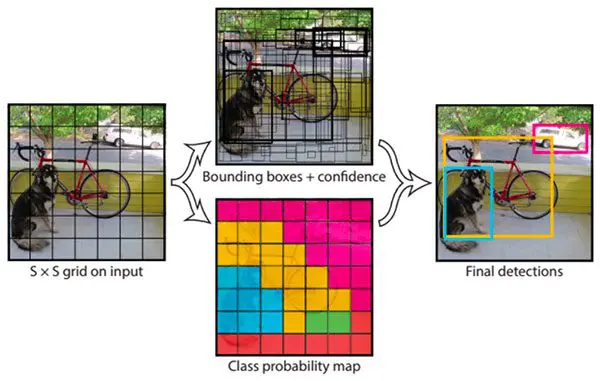

As mentioned, the image is divided into an S × S grid and for each grid cell predicts B bounding boxes. Class probabilities for the C classes are predicted for a grid cell, not each bounding box!
Therefore, the full output of YOLO has the shape:  
S * S * (B ∗ 5 + C)  

The original paper trained the model with:
* S=7 (7*7 grid)
* B=2 (2 boxes per grid cell)
* C=20 (20 classes of objects).

Therefore the output shape is 7 * 7 * (2*5+20) = 7 * 7 * 30 which is also shown in the image from the paper:

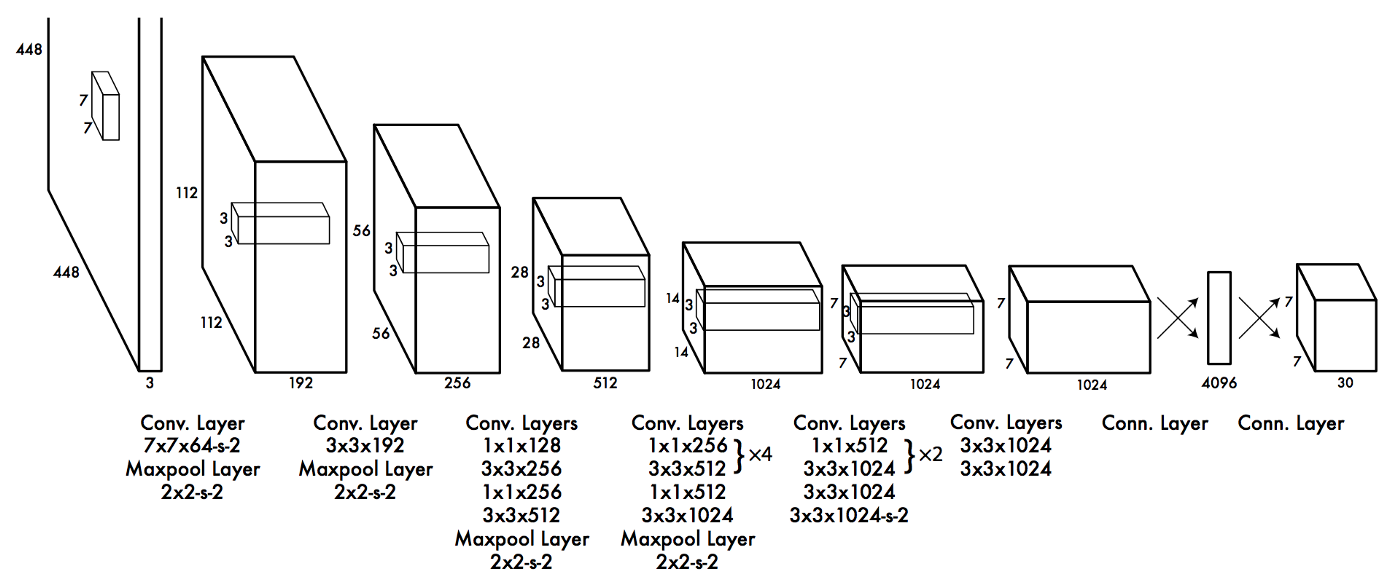

Since 2015 multiple improved versions of YOLO have been released that make slight changes by e.g. inclduing addiotional layers (BatchNorm), improving the resolution, or data augmentation techniques:



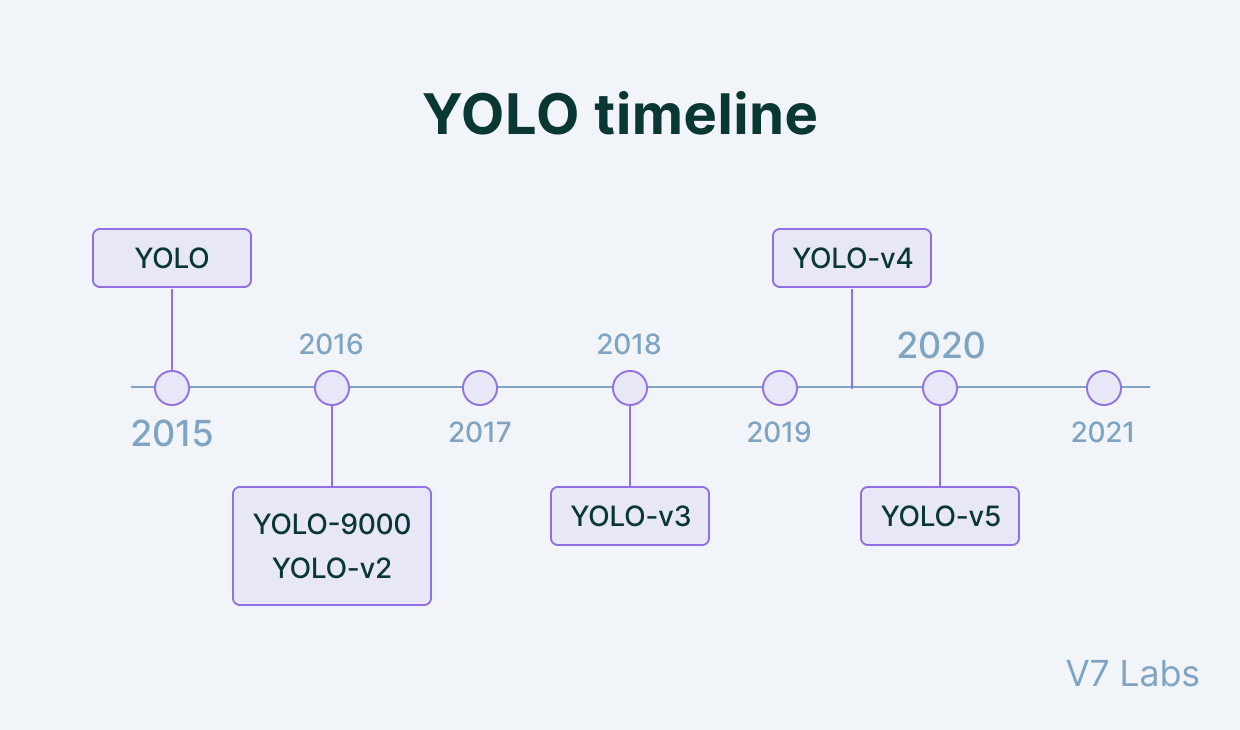

### 7. References 



*   https://www.madrasresearch.org/post/step-by-step-yolo-algorithm
*   https://www.analyticsvidhya.com/blog/2020/08/selecting-the-right-bounding-box-using-non-max-suppression-with-implementation/
* https://www.v7labs.com/blog/yolo-object-detection
* https://towardsdatascience.com/yolo-you-only-look-once-real-time-object-detection-explained-492dc9230006
* ["You Only Look Once: Unified, Real-Time Object Detection", Redmon et al.](https://arxiv.org/abs/1506.02640)







# Code it yourself

In this section, you will gain a better understanding of how some key concepts of the YOLO model work by implementing the functions yourself!

Import libraries needed: 








In [ ]:
import numpy as np
import tensorflow as tf

### Task A : Implement IoU

In this exercise only, we define a box using its two corners (upper left and lower right): (x1, y1, x2, y2) rather than the midpoint and height/width.  

To calculate the area of a rectangle you need to multiply its height (y2 - y1) by its width (x2 - x1).  

You'll also need to find the coordinates (xi1, yi1, xi2, yi2) of the intersection of two boxes. Remember that:
* xi1 = maximum of the x1 coordinates of the two boxes
* yi1 = maximum of the y1 coordinates of the two boxes
* xi2 = minimum of the x2 coordinates of the two boxes
* yi2 = minimum of the y2 coordinates of the two boxes

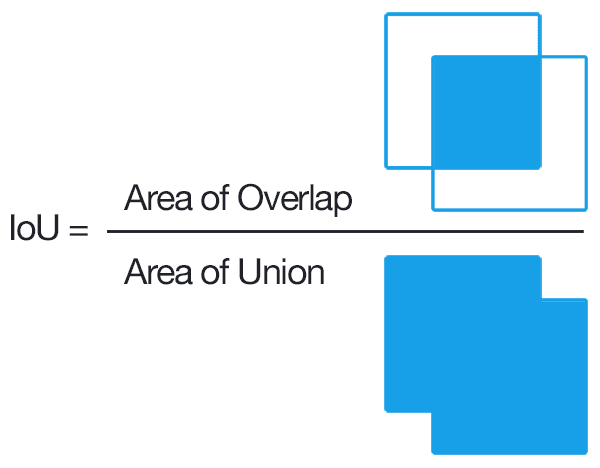

In [ ]:
def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2
    Arguments:
    box1 -- first box, list object with coordinates (x1, y1, x2, y2)
    box2 -- second box, list object with coordinates (x1, y1, x2, y2)
    """

    # Calculate the (y1, x1, y2, x2) coordinates of the intersection of box1 and box2.
    # Calculate the intersection area.
    # If the boxes do not overlap, the intersection area must be 0
    
    intersection_area = 1 # TODO
    

    # Calculate the union area by using the formula: Union(A,B) = A + B - Intersection(A,B)
    
    union_area = 1 # TODO

    # compute the IoU
    iou = float(intersection_area)/float(union_area)

    return iou


The expected output is  
`iou = 0.14285714285714285`

In [ ]:
box1 = (2, 1, 4, 3)
box2 = (1, 2, 3, 4) 
print("iou = " + str(iou(box1, box2)))

### Task B: Implement YOLO filter boxes

Compute box scores by doing the elementwise product as described in Figure 4. The following code may help you choose the right operator:
* a = np.random.randn(19*19, 5, 1)
* b = np.random.randn(19*19, 5, 80)
* c = a * b # shape of c will be (19*19, 5, 80)


For each box, find:
* The index of the class with the maximum box score  (Be careful with what axis you choose; consider using axis=-1)
* The corresponding box score  (Be careful with what axis you choose; consider using axis=-1)
* Create a mask by using a threshold. As a reminder: ([0.9, 0.3, 0.4, 0.5, 0.1] < 0.4) returns: [False, True, False, False, True]. The mask should be True for the boxes you want to keep.
* Use TensorFlow to apply the mask to box_class_scores, boxes and box_classes to filter out the boxes we don't want. You should be left with just the subset of boxes you want to keep.

In [ ]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    """Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
    box_confidence -- tensor of shape (19, 19, 5, 1)
    boxes -- tensor of shape (19, 19, 5, 4)
    box_class_probs -- tensor of shape (19, 19, 5, 80)
    threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    
    Returns:
    scores -- tensor of shape (None,), containing the class probability score for selected boxes
    boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
    classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes
    
    Note: "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold. 
    For example, the actual output size of scores would be (10,) if there are 10 boxes.
    """
    
    # Step 1: Compute box scores
    box_scores = None # TODO
    
    # Step 2: Find the box_classes thanks to the max box_scores, keep track of the corresponding score
    # For each of the bounding boxes, index of the maximum value of the probability vector.
    box_classes = None # TODO
    box_class_scores = None # TODO
    
    # Step 3: Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
    # same dimension as box_class_scores, and be True for the boxes you want to keep (with probability >= threshold)
    
    filtering_mask = None # TODO
    
    # Step 4: Apply the mask to scores, boxes and classes
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    
    return scores, boxes, classes

In [ ]:
tf.random.set_seed(42)
box_confidence = tf.random.normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1)
boxes = tf.random.normal([19, 19, 5, 4], mean=1, stddev=4, seed = 1)
box_class_probs = tf.random.normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1)

Expected output:  


```
scores[2] = 26.637585  
boxes[2] = [ 3.6244028 -1.2655537  1.6726924  3.6594343]  
classes[2] = 28  
scores.shape = (1785,)  
boxes.shape = (1785, 4)  
classes.shape = (1785,)
```

  

In [ ]:
scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = 0.5)
print("scores[2] = " + str(scores[2].numpy()))
print("boxes[2] = " + str(boxes[2].numpy()))
print("classes[2] = " + str(classes[2].numpy()))
print("scores.shape = " + str(scores.shape))
print("boxes.shape = " + str(boxes.shape))
print("classes.shape = " + str(classes.shape))

### Task C : Implement non-max suppression.

The key steps are:
* Select the box that has the highest score.
* Compute its overlap with all other boxes, and remove boxes that overlap it more than iou_threshold.
* Go back to step 1 and iterate until there's no more boxes with a lower score than the current selected box.

This will remove all boxes that have a large overlap with the selected boxes. Only the "best" boxes remain.

Exercise: Implement yolo_non_max_suppression() using TensorFlow. TensorFlow has two built-in functions that are used to implement non-max suppression (so you don't actually need to use your iou() implementation).

In [ ]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes=10, iou_threshold=0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes

    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering

    Returns:
    scores -- tensor of shape (, None), predicted score for each box
    boxes -- tensor of shape (4, None), predicted box coordinates
    classes -- tensor of shape (, None), predicted class for each box

    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. Note also that this
    function will transpose the shapes of scores, boxes, classes. This is made for convenience.
    """

    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    nms_indices = None # TODO

    # Use tf.keras.backend.gather() to select only nms_indices from scores, boxes and classes
    # Using the index for the boxes left, get the scores, box, and classes for each.
    scores = tf.keras.backend.gather(scores, nms_indices)
    boxes = tf.keras.backend.gather(boxes, nms_indices)
    classes = tf.keras.backend.gather(classes, nms_indices)

    return scores, boxes, classes

Expected output:  
```
scores[2] = 8.131492  
boxes[2] = [-4.283764   -3.8969646  -9.95371    -0.30319464]  
classes[2] = -5.424111  
scores.shape = (10,)  
boxes.shape = (10, 4)  
classes.shape = (10,)
```


In [ ]:
tf.random.set_seed(42)
scores = tf.random.normal([54,], mean=1, stddev=4, seed = 1)
boxes = tf.random.normal([54, 4], mean=1, stddev=4, seed = 1)
classes = tf.random.normal([54,], mean=1, stddev=4, seed = 1)
scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes)
print("scores[2] = " + str(scores[2].numpy()))
print("boxes[2] = " + str(boxes[2].numpy()))
print("classes[2] = " + str(classes[2].numpy()))
print("scores.shape = " + str(scores.numpy().shape))
print("boxes.shape = " + str(boxes.numpy().shape))
print("classes.shape = " + str(classes.numpy().shape))

### References



https://github.com/AdalbertoCq/Deep-Learning-Specialization-Coursera/blob/master/Convolutional%20Neural%20Networks/week3/yolo.py



# Fine-tuning YOLOv5


- This tutorial is broken into 6 parts:

        Part 1 : What is YOLOv5?
        Part 2 : The network architecture
        Part 3 : The dataset
        Part 4 : Training the YOLOv5 model
        Part 5 : Evaluating the performance on the validation set
        Part 6 : Running inference on the test set

Sources


*   Official guides for YOLOv5 PyTorch implementation [(specifically this notebook)](https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data)
*   "Self-Driving Car with YOLOv5 and Roboflow" by Herambh Dakshinamoorthy [(link)](https://medium.com/geekculture/self-driving-car-with-yolov5-and-roboflow-a5a2bf109c6)
*   "Self Driving Car Computer Vision Project" from Roboflow [(link)](https://universe.roboflow.com/roboflow-gw7yv/self-driving-car)



### Part 1: What is YOLOv5? 

- YOLOv5 is based on the YOLO detection architecture and uses the excellent
algorithm optimization strategy in the field of convolutional neural networks in recent years,
such as auto learning bounding box anchors, mosaic data augmentation, the cross-stage
partial network, and more. These improvements are part of different functions in different locations
of the YOLOv5 architecture.


*    In the architecture, YOLOv5 consists of four main parts: input,
backbone, neck, and output.

*   YOLOv5 has an open-source implementation. Please have a look to understand the structure of the repository we will use:  
https://github.com/ultralytics/yolov5







### Part 2: The network architecture



> The network architecture of Yolov5 consists of three parts: (1) Backbone: CSPDarknet, 
(2) Neck: PANet, and (3) Head: Yolo Layer. 

The data is first input to CSPDarknet for feature extraction, and then fed to PANet for feature fusion. Finally, Yolo Layer outputs detection results (class, score, location, size).



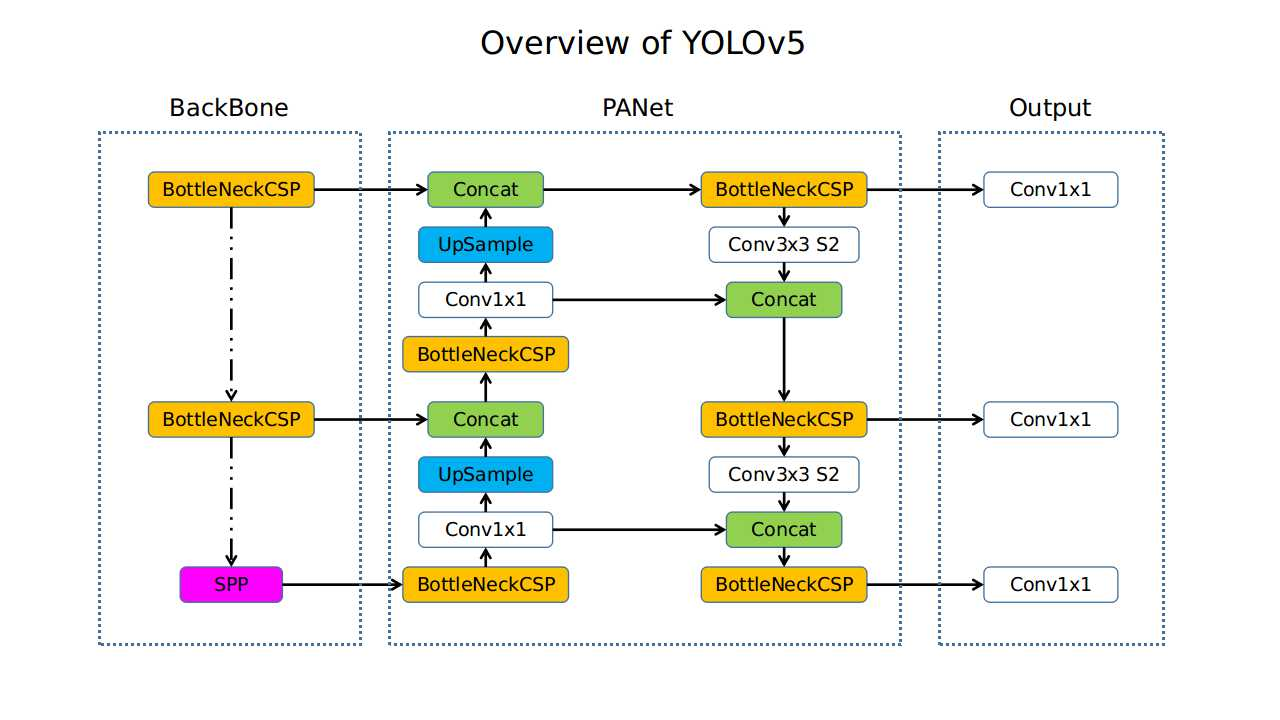

### Part 3: The dataset

In addition to the implementation, the open-source project also includes weights for models already pre-trained on the MS COCO dataset.

> MS COCO (Microsoft Common Objects in Context) is a large-scale image dataset containing 328,000 images of everyday objects and humans. The dataset contains annotations you can use to train machine learning models to recognize, label, and describe objects.







> MC COCO provides many types of annotation, one of which is:  
- Object detection—coordinates of bounding boxes 
and full segmentation masks for 80 categories of objects



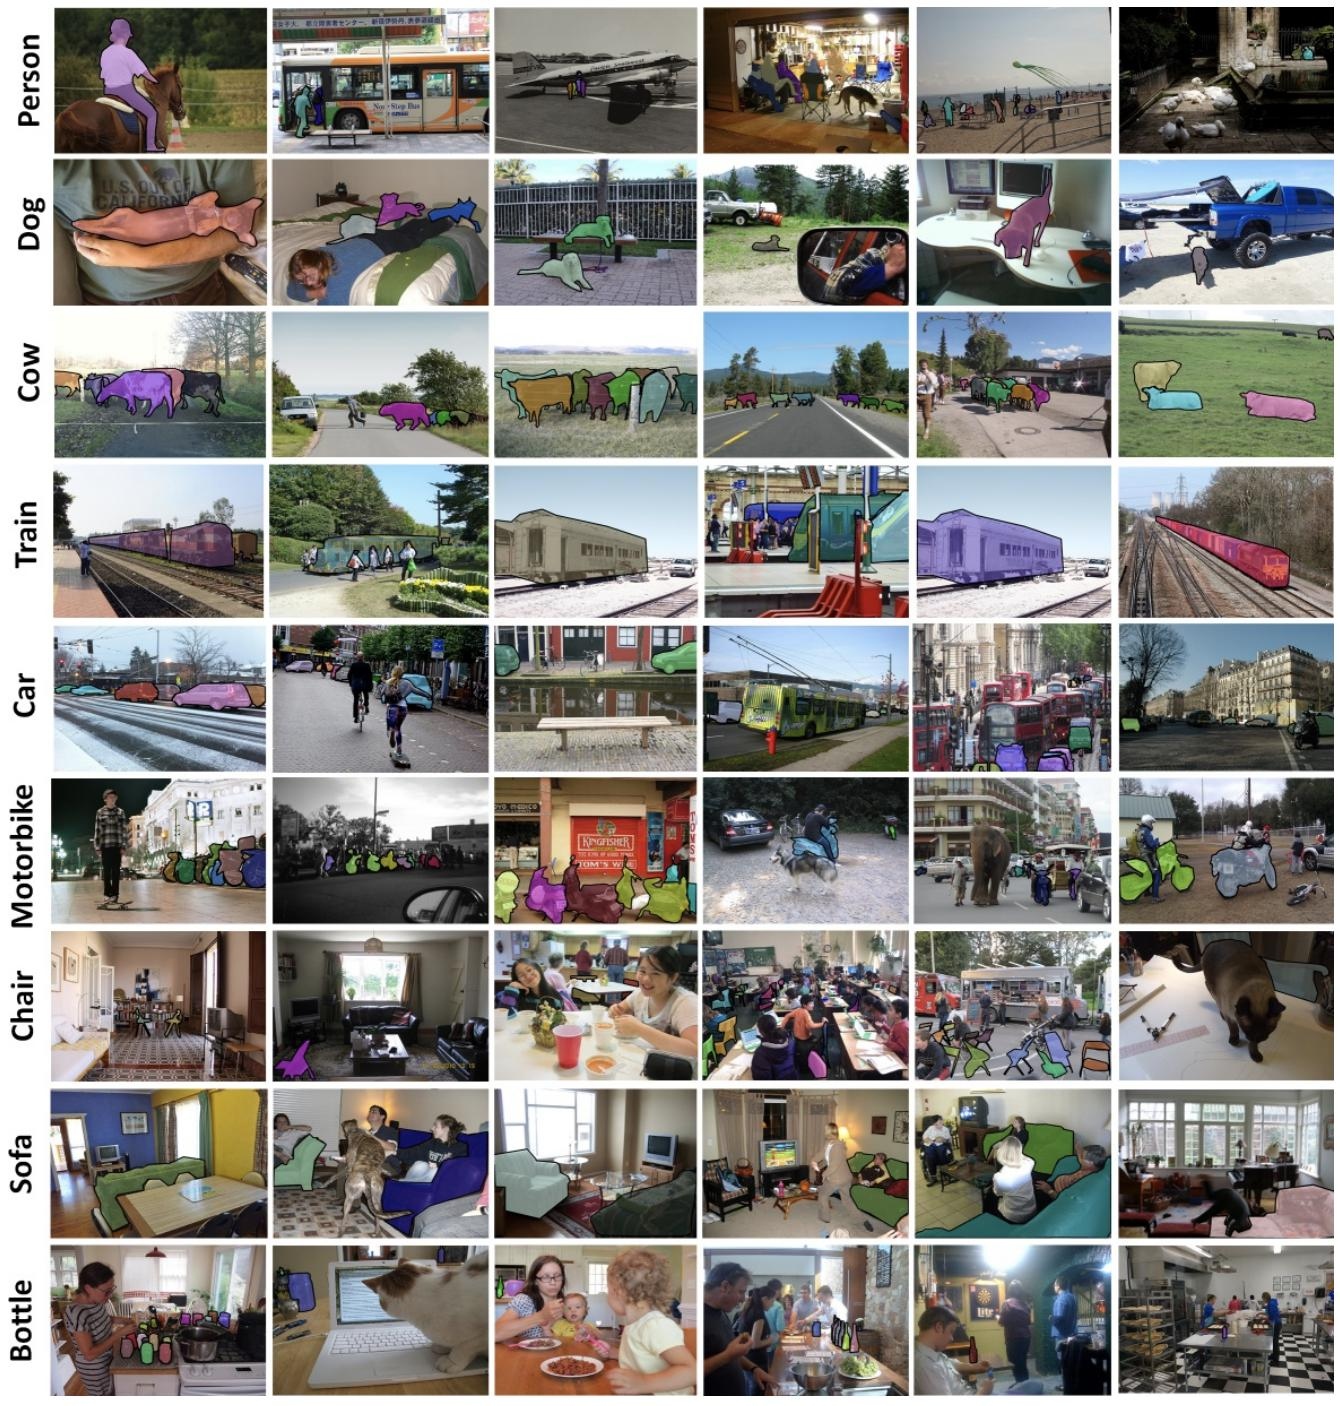

We will use an existing implementation of YOLOv5 and finetune the model on a dataset for self-driving.

Let's clone the github repo first.

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd /content/yolov5/

Next, we need to install the dependencies.

In [ ]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
# from utils.downloads import gdrive_download  # to download models/datasets

This will output the installed pytorch version and available GPU. If no GPU is detected, the code will run on CPU.

In [ ]:
print('Setup complete. Using torch %s on device %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'cpu'))

Next, we need to download the dataset from Roboflow. Normally, you will need to **create an account** at [roboflow.com](https://roboflow.com/). We already added the download code for you so you can skip this step if you want.


Once you are logged in, have a look at the [dataset](https://universe.roboflow.com/roboflow-gw7yv/self-driving-car).


The dataset contains 97,942 labels across 11 classes and 15,000 images. There are 1,720 null examples (images with no labels).  
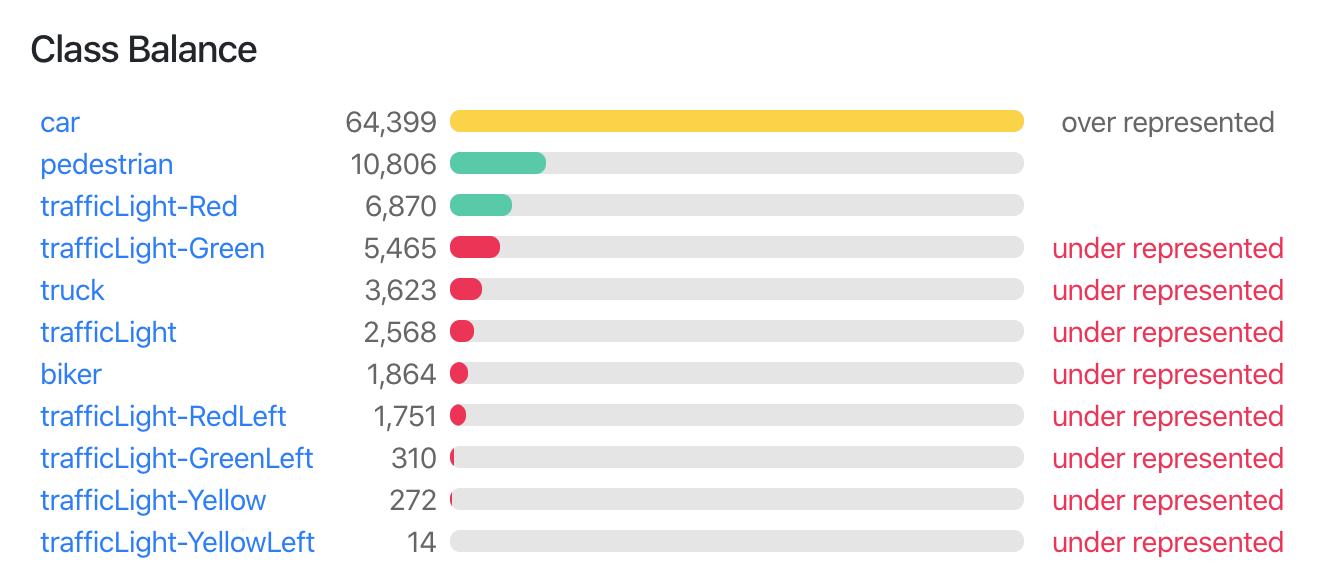


We will use a version with images of size 512x512.
To download it, navigate to Dataset->fixed-small->YOLOv5 which will open a dialogue to download the dataset in the correct YOLO v5 PyTorch format.  
Instead of downloading the dataset directly, we will generate the python code to download the dataset and paste it into the next cell.  
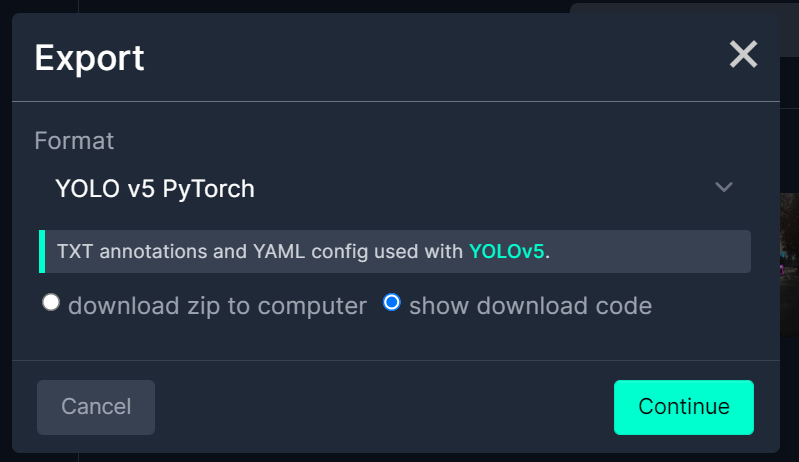

The code should look similar to this:


```
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="h3sfkhsd3fhs4kd6fh")
project = rf.workspace("roboflow-ab1cd").project("self-driving-car")
dataset = project.version(3).download("yolov5")
```



In [ ]:
# We already pasted the code for you
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="9XuVNjg7jr9GhQdxhvRg")
project = rf.workspace("roboflow-gw7yv").project("self-driving-car")
dataset = project.version(3).download("yolov5")

Now that the dataset is downloaded, we have to perform a train-validation-test split. The project already comes with an autosplit function that performs the split.  
Afterwards, we simply have to adjust the yaml config file accordingly.

In [ ]:
from utils.dataloaders import autosplit
import yaml

autosplit('./Self-Driving-Car-3/export', weights=(0.8, 0.1, 0.1))

with open("./Self-Driving-Car-3/data.yaml") as f:
     data = yaml.safe_load(f)

data["train"] = "Self-Driving-Car-3/autosplit_train.txt"
data["val"] = "Self-Driving-Car-3/autosplit_val.txt"
data["test"] = "Self-Driving-Car-3/autosplit_test.txt"

with open("./Self-Driving-Car-3/data.yaml", "w") as f:
    yaml.dump(data, f)

Since inference can unfortunately not use the txt file directly, we need to move all images listed in autosplit_test.txt to a separate folder.

In [ ]:
%cd /content/yolov5/Self-Driving-Car-3/

In [ ]:
import shutil
import os

os.makedirs(f"{dataset.location}/test/images", exist_ok=True)
os.makedirs(f"{dataset.location}/test/labels", exist_ok=True)

with open(f"{dataset.location}/autosplit_test.txt") as test_files:
    for filename in test_files:
        filename = filename.strip()
        if os.path.exists(filename):
          filename_label = (filename[:-3]+"txt").replace("images", "labels")
          new_filename_image = os.path.join(f"{dataset.location}/test/images", filename.split("/")[-1])
          new_filename_label = os.path.join(f"{dataset.location}/test/labels", filename.split("/")[-1][:-3]+"txt")
          shutil.move(filename, new_filename_image)
          shutil.move(filename_label, new_filename_label)

In [ ]:
%cd /content/yolov5/

### Part 4: Training the YOLOv5 model

Now that we have downloaded the dataset, we can finetune a pretrained YOLOv5 model on this dataset. Fortunately, the project contains a finished python script with the needed code. We simply need to pass the right arguments to it.

Available arguments include:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs
- **data:** Our dataset location is saved in the `dataset.location` variable
- **weights:** specify a path to weights to start transfer learning from. Here we choose the generic COCO pretrained checkpoint.
- **cache:** cache images for faster training
- **device:** The device for training, meaning the cuda device index (i.e. 0 or 0,1,2,3) or cpu.

In [ ]:
%cd /content/yolov5/

In [ ]:
!python train.py --img 512 --batch 32 --epochs 2 --data {dataset.location}/data.yaml --weights yolov5s.pt --device {"0" if torch.cuda.is_available() else "cpu"}

### Part 5: Evaluating the performance on the validation set

**Local Logging:**

Results during training are automatically logged with [Tensorboard](https://www.tensorflow.org/tensorboard) and [CSV](https://github.com/ultralytics/yolov5/pull/4148) loggers to `runs/train`, with a new experiment directory created for each new training as `runs/train/exp2`, `runs/train/exp3`, etc.

This directory contains train and val statistics, mosaics, labels, predictions, and augmented mosaics, as well as metrics and charts including precision-recall (PR) curves and confusion matrices. 

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%reload_ext tensorboard
%tensorboard --logdir runs

In [ ]:
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/exp/results.png', width=1000)  # view results.png

In [ ]:
# first, display our ground truth validation data
print("GROUND TRUTH VALIDATION DATA:")
Image(filename='/content/yolov5/runs/train/exp/val_batch0_labels.jpg', width=900)

In [ ]:
# second, display the predictions on the validation data
print("PREDICTION VALIDATION DATA:")
Image(filename='/content/yolov5/runs/train/exp/val_batch0_pred.jpg', width=900)

### Part 6: Running inference on the test set

In [ ]:
!python detect.py --weights runs/train/exp/weights/best.pt --img 512 --source {dataset.location}/test/images

In [ ]:
#display inference on the first 10  test images

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp/*.jpg')[:10]:
    display(Image(filename=imageName))